In [111]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPooling2D,Flatten, Reshape, Dropout, BatchNormalization,LeakyReLU, Conv2DTranspose
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras import optimizers
from keras import layers
import keras
from keras.datasets import cifar10

In [112]:
buffer_size = 10000
batch_size = 256
# load the pre-shuffled train and test data
(train_images, _), (_, _) = cifar10.load_data()

##### please do normalization before train
train_images = (train_images - 127.5) / 127.5 
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [113]:
discriminator = Sequential([
    Conv2D(128, (5,5), strides = (2,2), padding = 'same', input_shape = (32,32,3)), # input_shape = (64,64,3)
    LeakyReLU(),
    Dropout(0.2),
    
    Conv2D(256, (5,5), strides = (2,2), padding = 'same'),
    LeakyReLU(),
    Dropout(0.2),
    
    Conv2D(512, (5,5), strides = (2,2), padding = 'same'),
    LeakyReLU(),
    Dropout(0.2),
    
    Conv2D(1024, (5,5), strides = (2,2), padding = 'same'),
    LeakyReLU(),
    Dropout(0.2),
    
    Dense(1, activation = 'sigmoid')
])

In [114]:
in_shape = [32,32,3]
discriminator = Sequential()
# normal
discriminator.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
discriminator.add(LeakyReLU(alpha=0.2))
# downsample
discriminator.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
# downsample
discriminator.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
# downsample
discriminator.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
# classifier
discriminator.add(Flatten())
discriminator.add(Dropout(0.4))
discriminator.add(Dense(1, activation='sigmoid'))

In [115]:
latent_dim = 100
generator = Sequential()
# foundation for 4x4 image
n_nodes = 256 * 4 * 4
generator.add(Dense(n_nodes, input_dim=latent_dim))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Reshape((4, 4, 256)))
# upsample to 8x8
generator.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
generator.add(LeakyReLU(alpha=0.2))
# upsample to 16x16
generator.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
generator.add(LeakyReLU(alpha=0.2))
# upsample to 32x32
generator.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
generator.add(LeakyReLU(alpha=0.2))
# output layer
generator.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))

In [77]:
generator = Sequential([
    Dense(2*2*1024, input_shape = (100,), use_bias = False),
    BatchNormalization(),
    LeakyReLU(),
    
    Reshape((2,2,1024)),
    
    Conv2DTranspose(512,(5,5), strides = (2,2),padding = 'same',use_bias = False),
    BatchNormalization(),
    LeakyReLU(),
    
    Conv2DTranspose(256,(5,5), strides = (2,2),padding = 'same',use_bias = False),
    BatchNormalization(),
    LeakyReLU(),
    
    Conv2DTranspose(128,(5,5), strides = (2,2),padding = 'same',use_bias = False),
    BatchNormalization(),
    LeakyReLU(),
    
    Conv2DTranspose(3,(5,5), strides = (2,2),padding = 'same',use_bias = False, activation ='sigmoid')
])

In [116]:
generator.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 4096)              413696    
                                                                 
 leaky_re_lu_85 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_9 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_33 (Conv2D  (None, 8, 8, 128)        524416    
 Transpose)                                                      
                                                                 
 leaky_re_lu_86 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_34 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                          

In [117]:
discriminator.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_81 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_82 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_52 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_83 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_53 (Conv2D)          (None, 4, 4, 256)       

In [118]:
binary_crossentropy = keras.losses.BinaryCrossentropy(from_logits=False)

def generator_loss(disc_out_put_for_gen_imgs):
    return binary_crossentropy(tf.ones_like(disc_out_put_for_gen_imgs), disc_out_put_for_gen_imgs)
# we want disc_out_put_for_gen_imgs all close to 1 which means discriminator think gen_imgs are true imges

def discriminator_loss(disc_out_put_for_true_imgs, disc_out_put_for_gen_imgs):
    disc_loss_for_true = binary_crossentropy(tf.zeros_like(disc_out_put_for_gen_imgs), disc_out_put_for_gen_imgs)
    disc_loss_for_gen = binary_crossentropy(tf.ones_like(disc_out_put_for_true_imgs), disc_out_put_for_true_imgs)
    return disc_loss_for_true+disc_loss_for_gen


generator_opt = optimizers.Adam(learning_rate=0.0002)
discriminator_opt = optimizers.Adam(learning_rate=0.0002)

In [119]:
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim, ])
    for i in range(0,3):
        with tf.GradientTape() as disc_tape:
            gen_imgs = generator(noise, training = False)

            disc_out_put_for_true_imgs = discriminator(images, training = True)
            disc_out_put_for_gen_imgs = discriminator(gen_imgs, training = True)

            disc_loss = discriminator_loss(disc_out_put_for_true_imgs,disc_out_put_for_gen_imgs)
            gen_loss = generator_loss(disc_out_put_for_gen_imgs)
        gradient_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_opt.apply_gradients(zip(gradient_disc, discriminator.trainable_variables))
        
    with tf.GradientTape() as gen_tape:
        gen_imgs = generator(noise, training = True)

        disc_out_put_for_true_imgs = discriminator(images, training = False)
        disc_out_put_for_gen_imgs = discriminator(gen_imgs, training = False)

        disc_loss = discriminator_loss(disc_out_put_for_true_imgs,disc_out_put_for_gen_imgs)
        gen_loss = generator_loss(disc_out_put_for_gen_imgs)
    
    gradient_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_opt.apply_gradients(zip(gradient_gen, generator.trainable_variables))

In [120]:
def generate_plot_image(gen_model, test_noise):
    pre_images = gen_model(test_noise, training = False)
    fig = plt.figure(figsize = (4,4))
    for i in range(pre_images.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((pre_images[i,:,:,:] +1)/2, cmap = 'gray')
        plt.axis('off')
    plt.show()

In [121]:
def train(ds, epochs):
    for epoch in range(epochs):
        for image_batch in ds:
            train_step(image_batch)
            print('.', end = '')
        generate_plot_image(generator, seed)
        print('Epoch:'+str(epoch+1))

In [122]:
### prameters
noise_dim = 100
num_exp_to_generate = 16
seed = tf.random.normal([num_exp_to_generate,noise_dim])

....................................................................................................................................................................................................

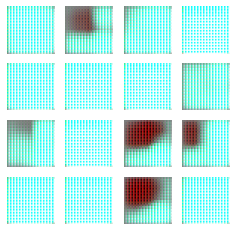

Epoch:1
....................................................................................................................................................................................................

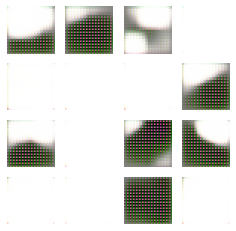

Epoch:2
....................................................................................................................................................................................................

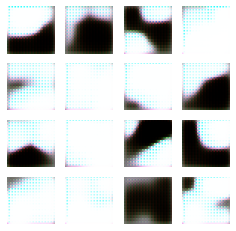

Epoch:3
....................................................................................................................................................................................................

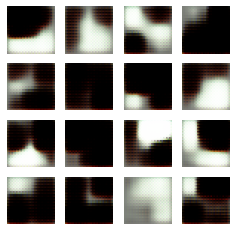

Epoch:4
....................................................................................................................................................................................................

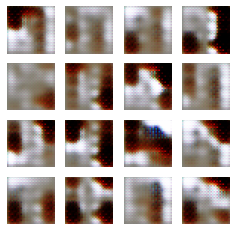

Epoch:5


In [123]:
epochs = 5
train(train_dataset, epochs)

....................................................................................................................................................................................................

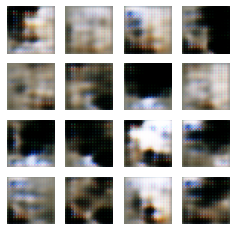

Epoch:1
....................................................................................................................................................................................................

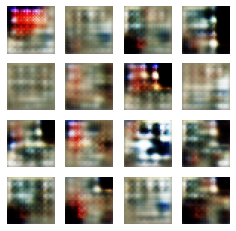

Epoch:2
....................................................................................................................................................................................................

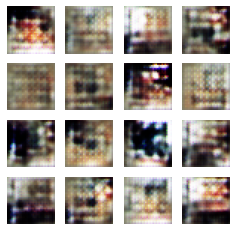

Epoch:3
....................................................................................................................................................................................................

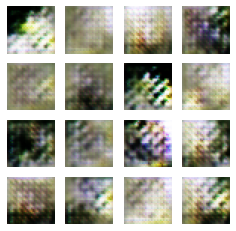

Epoch:4
....................................................................................................................................................................................................

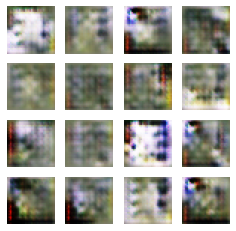

Epoch:5
....................................................................................................................................................................................................

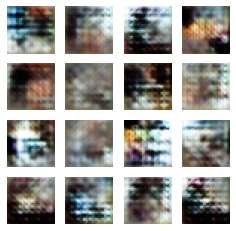

Epoch:6
....................................................................................................................................................................................................

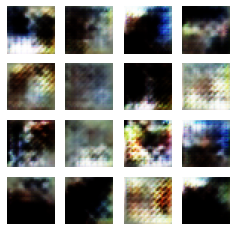

Epoch:7
....................................................................................................................................................................................................

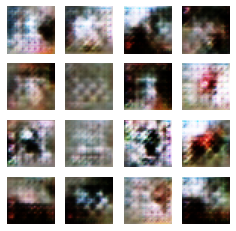

Epoch:8
....................................................................................................................................................................................................

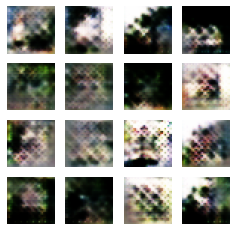

Epoch:9
....................................................................................................................................................................................................

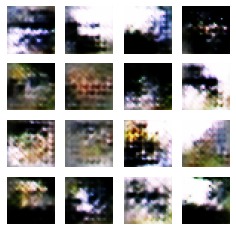

Epoch:10
....................................................................................................................................................................................................

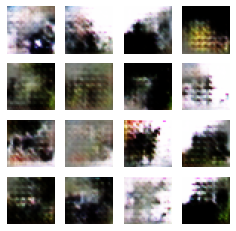

Epoch:11
....................................................................................................................................................................................................

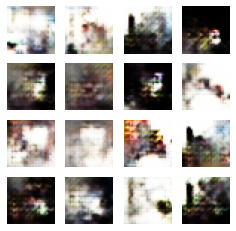

Epoch:12
....................................................................................................................................................................................................

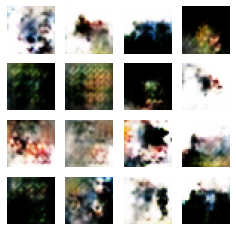

Epoch:13
....................................................................................................................................................................................................

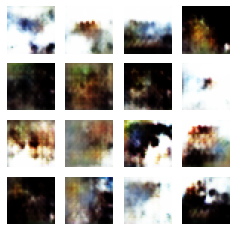

Epoch:14
....................................................................................................................................................................................................

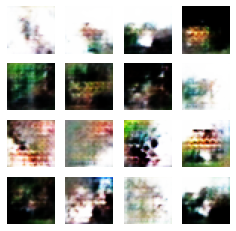

Epoch:15
....................................................................................................................................................................................................

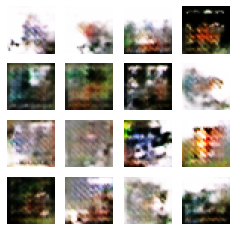

Epoch:16
....................................................................................................................................................................................................

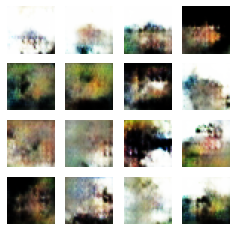

Epoch:17
....................................................................................................................................................................................................

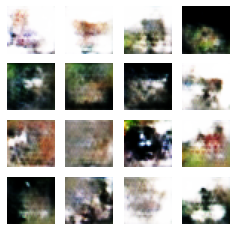

Epoch:18
....................................................................................................................................................................................................

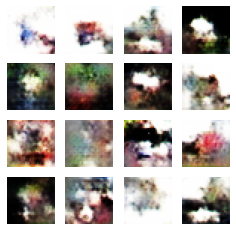

Epoch:19
....................................................................................................................................................................................................

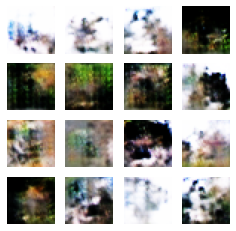

Epoch:20
....................................................................................................................................................................................................

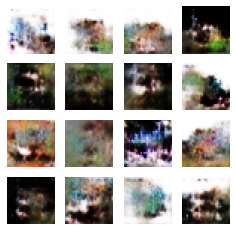

Epoch:21
....................................................................................................................................................................................................

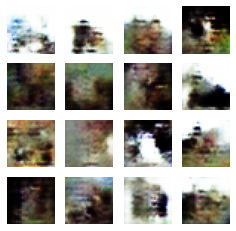

Epoch:22
....................................................................................................................................................................................................

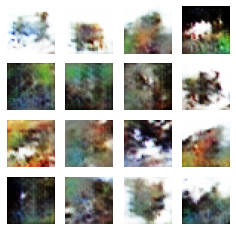

Epoch:23
....................................................................................................................................................................................................

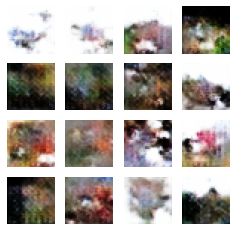

Epoch:24
....................................................................................................................................................................................................

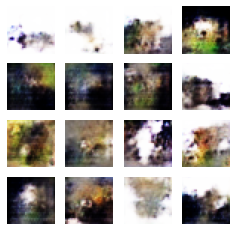

Epoch:25
....................................................................................................................................................................................................

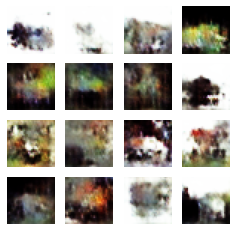

Epoch:26
....................................................................................................................................................................................................

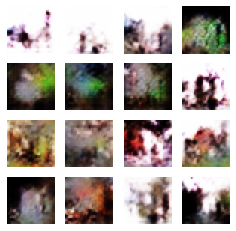

Epoch:27
....................................................................................................................................................................................................

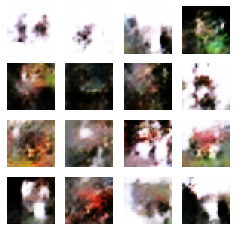

Epoch:28
....................................................................................................................................................................................................

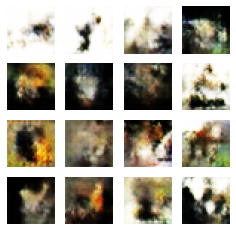

Epoch:29
....................................................................................................................................................................................................

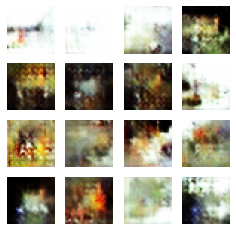

Epoch:30
....................................................................................................................................................................................................

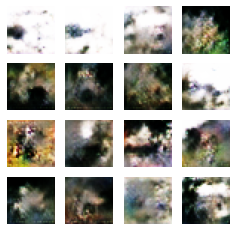

Epoch:31
....................................................................................................................................................................................................

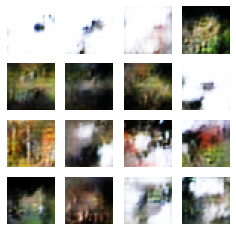

Epoch:32
....................................................................................................................................................................................................

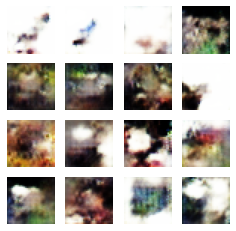

Epoch:33
....................................................................................................................................................................................................

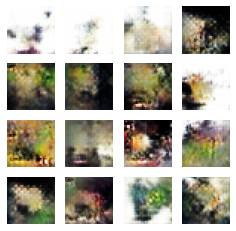

Epoch:34
....................................................................................................................................................................................................

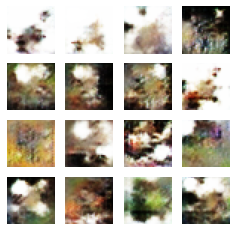

Epoch:35
....................................................................................................................................................................................................

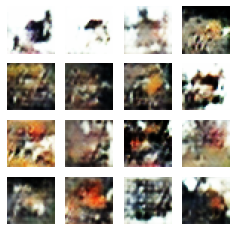

Epoch:36
....................................................................................................................................................................................................

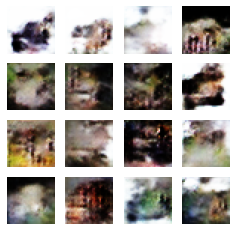

Epoch:37
....................................................................................................................................................................................................

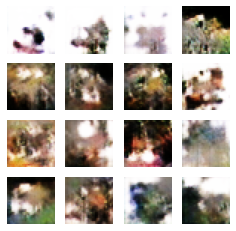

Epoch:38
....................................................................................................................................................................................................

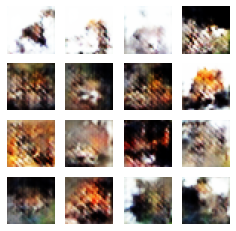

Epoch:39
....................................................................................................................................................................................................

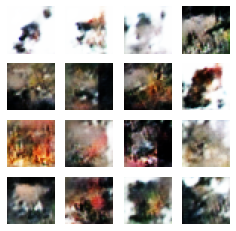

Epoch:40
....................................................................................................................................................................................................

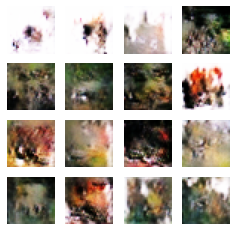

Epoch:41
....................................................................................................................................................................................................

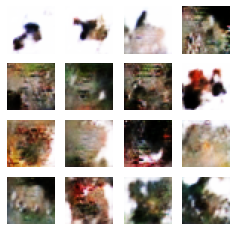

Epoch:42
....................................................................................................................................................................................................

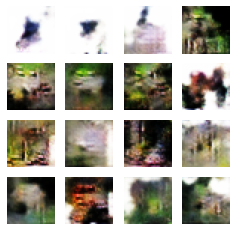

Epoch:43
....................................................................................................................................................................................................

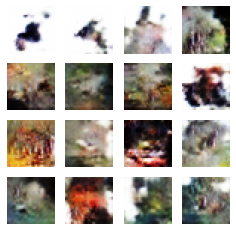

Epoch:44
....................................................................................................................................................................................................

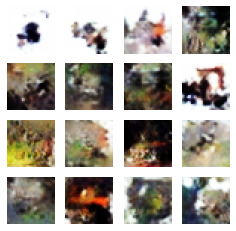

Epoch:45
....................................................................................................................................................................................................

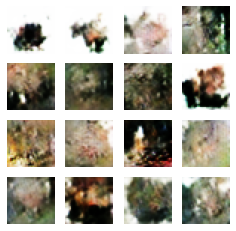

Epoch:46
....................................................................................................................................................................................................

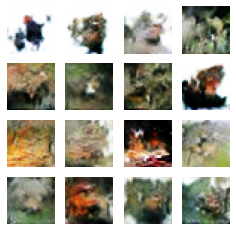

Epoch:47
....................................................................................................................................................................................................

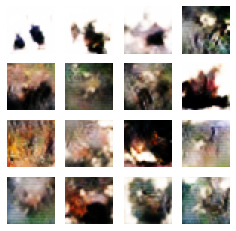

Epoch:48
....................................................................................................................................................................................................

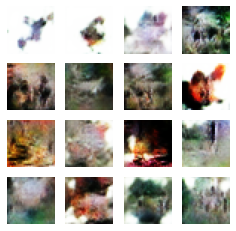

Epoch:49
....................................................................................................................................................................................................

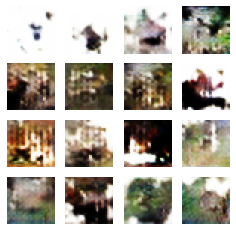

Epoch:50


In [124]:
epochs = 50
train(train_dataset, epochs)